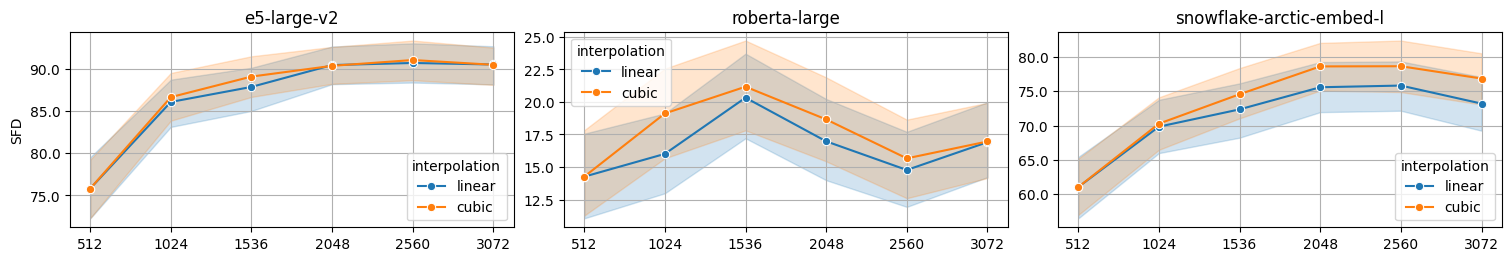

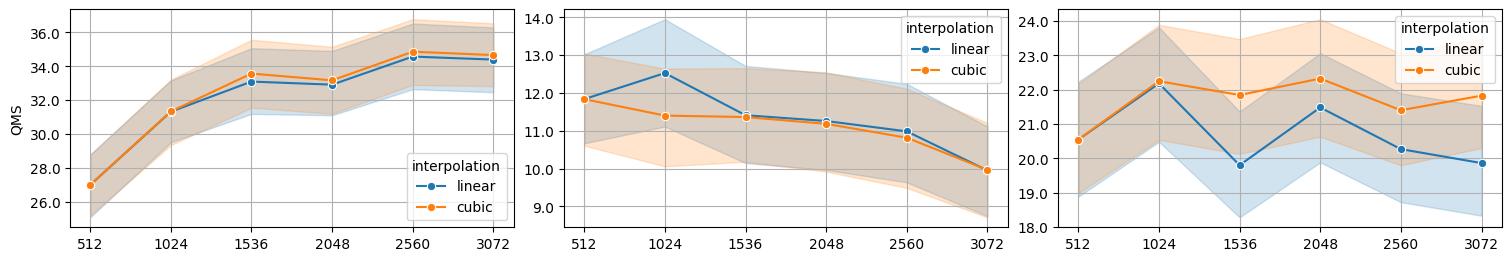

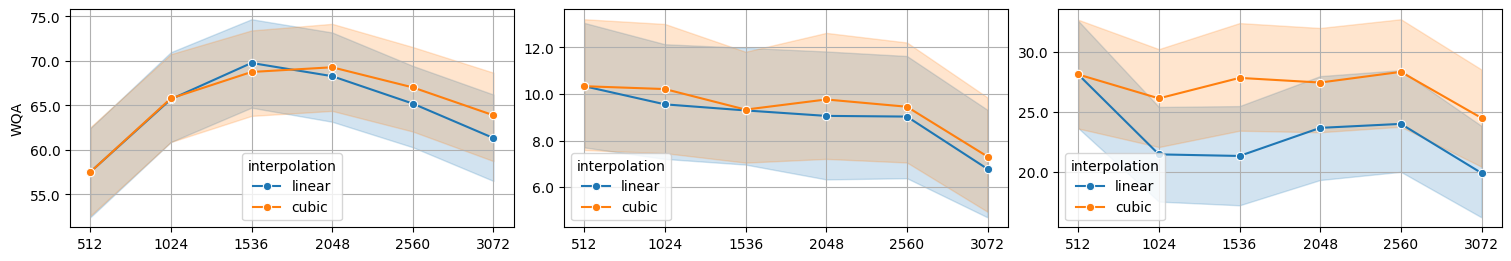

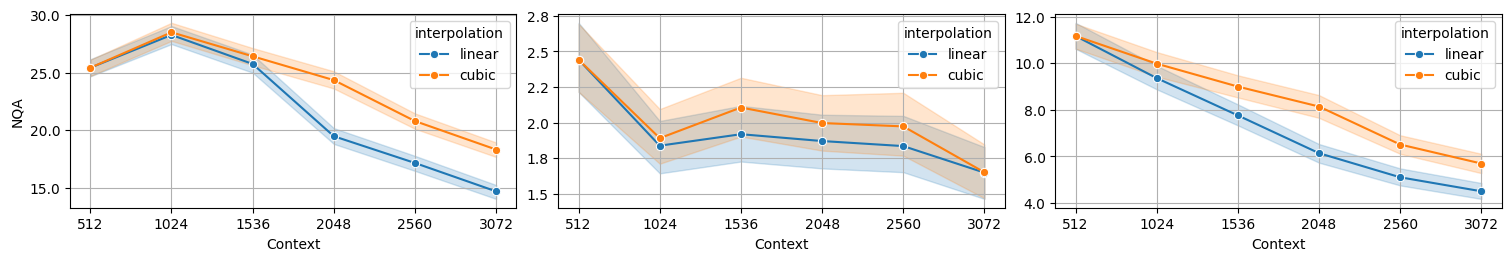

In [1]:
import re
import json
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

CONFIG_PATTERN = r'^(?P<model>.+?)-ctx(?P<context>\d+)-(?P<interpolation>linear|cubic|quadratic)$'
metric_col = 'ndcg_at_10'
metric_alias = metric_col.replace('_at_', '@').upper()

dataset_aliases = {
    'LEMBNarrativeQARetrieval': 'NQA',
    'LEMBSummScreenFDRetrieval': 'SFD',
    'LEMBQMSumRetrieval': 'QMS',
    'LEMBWikimQARetrieval': 'WQA',    
}

df = pd.DataFrame()
paths = [p for p in Path('../results').rglob('*jsonl') if p.stem != 'model_meta']
for path in paths:
    _df = pd.read_json(path, lines=True)
    _df.drop('task', axis=1, inplace=True)
    _df[metric_col] *= 100
    _df.rename({metric_col: metric_alias}, axis=1, inplace=True)
    
    config = re.match(CONFIG_PATTERN, path.parent.name).groupdict()
    for param, value in config.items():
        if param == 'model':
            value = value.split('/')[-1]
        _df[param] = value

    _df['dataset'] = dataset_aliases[path.stem]
    
    df = pd.concat([df, _df])

models = df['model'].unique()
datasets = df['dataset'].unique()
ncols = len(models)

for dataset in datasets:
    fig, axes = plt.subplots(
        1, ncols, figsize=(5 * ncols, 2.5), 
        # sharey=True,
        sharex=True, 
        constrained_layout=True
    )
    
    for i, model in enumerate(models):
        # select axis
        ax = axes[i] if ncols > 1 else axes

        # plot results
        df_filter = (df['dataset'] == dataset) & (df['model'] == model)
        sns.lineplot(
            data=df[df_filter],
            x='context',
            y=metric_alias,
            hue='interpolation',
            marker='o',
            ax=ax
        )

        # set title for first plot
        if dataset == datasets[0]:
            ax.set_title(model)
        
        # set axes names
        ax.set_ylabel(f'{dataset}' if i == 0 else '')
        ax.set_xlabel('Context' if dataset == datasets[-1] else '')
        # ax.get_legend().remove()
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.grid(True)

In [2]:
from scipy.stats import shapiro, ttest_rel, wilcoxon

less = 0
greater = 0
none = 0
for dataset_name, dataset_group in df[df['context'] != '512'].groupby('dataset'):
    for model_name, model_group in dataset_group.groupby('model'):
        for ctx, ctx_group in model_group.groupby('context'):
            ctx_group = ctx_group.sort_values('query_id')
            data1 = ctx_group[ctx_group['interpolation'] == 'linear'][metric_alias]
            data2 = ctx_group[ctx_group['interpolation'] == 'cubic'][metric_alias]
            
            _, p_less = wilcoxon(data1, data2, alternative='less')
            _, p_greater = wilcoxon(data1, data2, alternative='greater')

            less += p_less < 0.05
            greater += p_greater < 0.05
            none += (p_less >= 0.05) and (p_greater >= 0.05)

total = (less + greater + none) / 100
print(f'linear vs cubic\n---------------')
print(f'{less/total = :.1f}% (n = {less})')
print(f'{greater/total = :.1f}% (n = {greater})')
print(f'{none/total = :.1f}% (n = {none})')

linear vs cubic
---------------
less/total = 56.7% (n = 34)
greater/total = 3.3% (n = 2)
none/total = 40.0% (n = 24)


In [3]:
def compute_interpolation_deltas(df, metric_col: str = metric_col):
    df = df.sort_values('query_id')
    pivot = df.pivot_table(
        index=['model', 'context', 'dataset'],
        columns='interpolation',
        values=metric_alias
    ).dropna(subset=['linear', 'cubic'])  # Ensure both exist

    # Calculate delta (cubic - linear)
    pivot['delta'] = pivot['cubic'] - pivot['linear']

    # Reset index to return a flat DataFrame
    return pivot.reset_index()

# df_filter = (df['model'] != 'roberta-large') & (df['context'] != '512')
df_filter = (df['context'] != '512')
# df_filter = (df['model'] != 'roberta-large') & (df['context'].apply(int) >= 1048)
deltas = compute_interpolation_deltas(df[df_filter])

In [4]:
deltas['delta'].mean(), deltas['delta'].std()

(np.float64(1.289445415094472), np.float64(1.6211906776250455))

In [5]:
from scipy.stats import shapiro, ttest_rel, wilcoxon


def cohens_d_paired(x, y):
    diffs = x.values - y.values
    return diffs.mean() / diffs.std(ddof=1)


data1 = deltas['cubic']
data2 = deltas['linear']
diffs = data1.values - data2.values

# normality check
_, shapiro_p = shapiro(deltas['delta'].values)
print(f'Shapiro-Wilk: p={shapiro_p:.3g}')

# test
if shapiro_p > 0.05:
    _, p_val = ttest_rel(data1, data2)  # use t-test
    print(f't-test: p={p_val:.3g}')
else:
    _, p_val = wilcoxon(data1, data2)  # use wilcoxon
    print(f'Wilcoxon: p={p_val:.3g}')

# effect size
cohens_d = cohens_d_paired(data1, data2)  # Cohen's d
print(f'Cohen\'s d: {cohens_d:.3g}')

# delta
delta = abs(data1.mean() - data2.mean())
print(f'Delta: {delta:.3g}')

Shapiro-Wilk: p=1.02e-05
Wilcoxon: p=4.63e-09
Cohen's d: 0.795
Delta: 1.29
